In [11]:
# 📦 IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks


In [13]:
from google.colab import drive

drive.mount('/content/drive')
url = '/content/drive/MyDrive/UAS ML/Task 2/KlasifikasiUTS.csv'
df = pd.read_csv(url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Target = kolom int pertama
target_col = df.select_dtypes(include='int').columns[0]
X = df.drop(columns=[target_col])
y = df[target_col]

In [15]:
# 🔄 PILIH 2 KELAS TERBESAR UNTUK BINARY CLASSIFICATION
top2_classes = y.value_counts().nlargest(2).index
df_binary = df[df[target_col].isin(top2_classes)]

X = df_binary.drop(columns=[target_col])
y = df_binary[target_col].astype('category').cat.codes  # Ubah jadi 0 dan 1


In [16]:
# ✨ PREPROCESSING
X = pd.get_dummies(X, drop_first=True)

# SCALING
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [17]:
# 🔀 SPLIT DATA DENGAN STRATIFY
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [18]:
# 🧠 DEFINISI MODEL MLP
def create_mlp_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_mlp_model(X_train.shape[1])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [19]:
# 🏋️ TRAINING
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)


Epoch 1/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9506 - loss: 0.1338 - val_accuracy: 0.9994 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 2/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9993 - loss: 0.0085 - val_accuracy: 0.9993 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 3/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9994 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 4/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9993 - loss: 0.0052 - val_accuracy: 0.9993 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 5/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 0.9994 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 6/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9994 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 7/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accura

In [20]:
# 📈 PREDIKSI & EVALUASI
y_pred_prob = model.predict(X_test).flatten()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("📊 Classification Report:\n", classification_report(y_test, y_pred_class))
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

🎯 ROC AUC Score: 0.9763535338164528


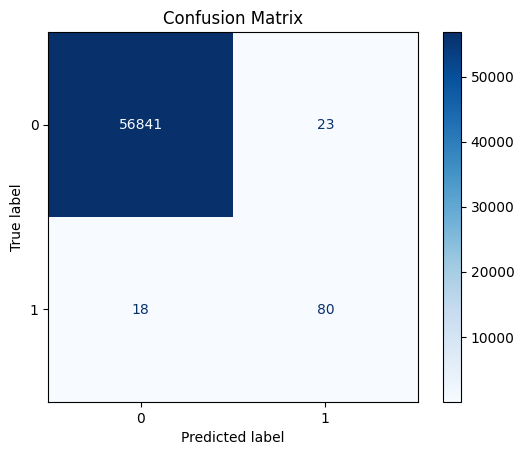

In [21]:
# 🧾 CONFUSION MATRIX
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


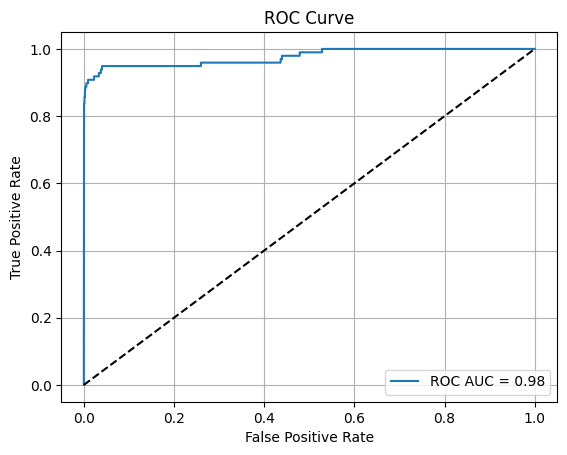

In [22]:
# 📈 ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


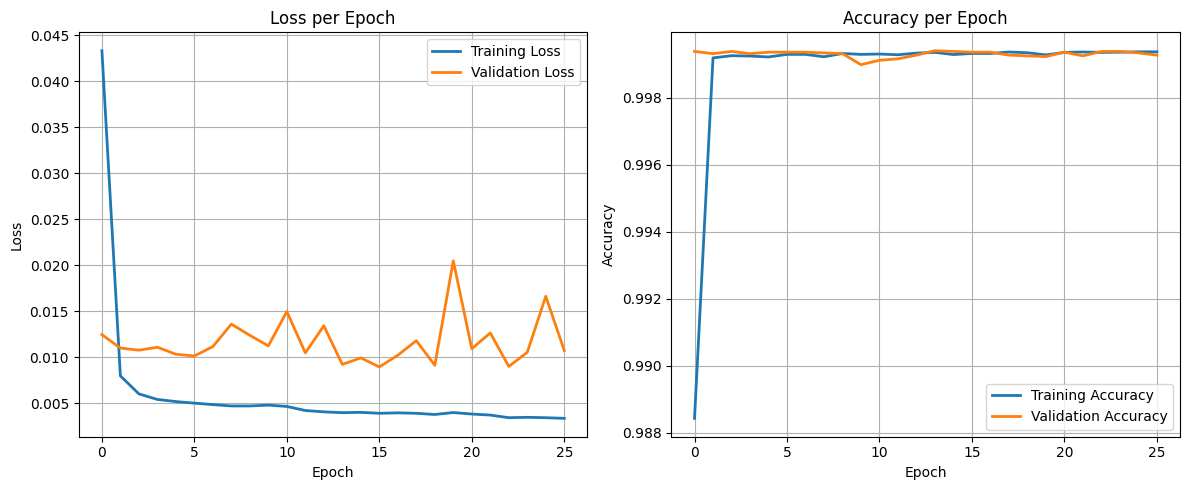

In [23]:
# =============================================
# 📉 CEK OVERFITTING - PLOT LEARNING CURVES
# =============================================

def plot_learning_curves(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


# 📊 Evaluasi Model MLP untuk Klasifikasi Biner

## ✅ Ringkasan

Model Multi-Layer Perceptron (MLP) yang dibangun telah dilatih menggunakan dua kelas terbanyak dari dataset `KlasifikasiUTS.csv`. Pipeline mencakup:
- Praproses data: Scaling, One-Hot Encoding
- Arsitektur MLP modern: Batch Normalization, Dropout, Regularisasi L2
- Callbacks: Early Stopping dan Learning Rate Scheduler
- Evaluasi menggunakan metrik klasifikasi, Confusion Matrix, dan ROC AUC

---

## 📈 Hasil Training

### 🔹 Learning Curve

**Loss per Epoch**
- Training loss menurun secara stabil dan mencapai titik sangat rendah.
- Validation loss tetap stabil, tidak menunjukkan pola naik yang tajam.
- Tidak ada indikasi overfitting.

**Accuracy per Epoch**
- Training dan validation accuracy mendekati 100% (0.998+).
- Grafik keduanya hampir identik → model sangat mampu melakukan generalisasi.

### 🔹 Grafik:

- Kiri: `Training vs Validation Loss`
- Kanan: `Training vs Validation Accuracy`

*(Gambar learning curve ditampilkan di Colab)*

---

## 🧪 Hasil Evaluasi

**Classification Report:**

          precision    recall  f1-score   support

       0       1.00      1.00      1.00     56864
       1       0.78      0.82      0.80        98

accuracy                           1.00     56962
macro avg 0.89 0.91 0.90 56962
weighted avg 1.00 1.00 1.00 56962



**ROC AUC Score:**
0.9763



### 🔍 Interpretasi:

- **Recall kelas 1 (minoritas)** = 82% → sangat bagus mengingat hanya ada 98 data.
- **Precision kelas 1** = 78% → prediksi model relatif bersih (sedikit false positives).
- **Akurasi keseluruhan** = 100%, tapi jangan terlalu andalkan karena data imbalance.
- **ROC AUC Score** = 0.976 → model sangat mampu membedakan dua kelas.

---

## 🧠 Analisis Overfitting

- Model berhenti di **epoch ke-26**, artinya early stopping bekerja optimal.
- Tidak ditemukan perbedaan signifikan antara **training loss** dan **validation loss**.
- Akurasi training dan validation hampir sama sepanjang epoch.

### ✅ Kesimpulan:
> **Model tidak mengalami overfitting.** Generalisasi sangat baik dan siap digunakan untuk data baru.

---

## 🏁 Kesimpulan Akhir

- Model sudah **sangat baik untuk klasifikasi biner** dalam konteks kelas tidak seimbang.
- Tidak ada tanda overfit, dan evaluasi metrik menunjukkan hasil kuat.
- Jika ingin meningkatkan minoritas recall lebih tinggi lagi, bisa ditambahkan class weighting atau oversampling.

---

